In [ ]:
pip install gurobipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from numpy.random import normal, randint
import gurobipy as gp
import matplotlib.pyplot as plt
from patsy import dmatrices
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")
GUROBI_TIMEOUT = 10
%matplotlib inline

In [ ]:
pip install gurobipy

In [ ]:

price_demand_data = pd.read_csv('price_demand_data.csv')
days = price_demand_data.shape[0]


## 1) Fit a linear regression model to this data set.

In [ ]:
y, x = dmatrices('demand ~ price', data=price_demand_data)
lr_model = sm.OLS(y, x)  
lr_model = lr_model.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 demand   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     159.3
Date:                Sat, 18 Feb 2023   Prob (F-statistic):           3.51e-22
Time:                        00:15:37   Log-Likelihood:                -636.17
No. Observations:                  99   AIC:                             1276.
Df Residuals:                      97   BIC:                             1282.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1924.7175    111.334     17.288      0.000    1703.750    2145.685
price      -1367.7125    108.379    -12.620      0.000   -1582.816   -1152.609
==============================================================================
Omnibus:                        0.906   Durbin-Watson:                   1.827
Prob(Omnibus):                  0.636   Jarque-Bera (JB):                0.871
Skew:                          -0.222   Prob(JB):                        0.647
Kurtosis:                       2.881   Cond. No.                         14.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#Using the residuals, assume the price is p=1 and generate demand data.
y_hat = lr_model.predict(x)
residuals = y.flatten() - y_hat


Text(0.5, 1.0, 'Price vs. Demand')

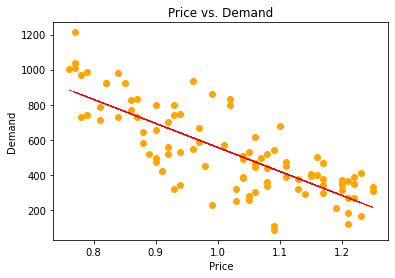

In [ ]:
plt.scatter(x= x[:,1], y= y, color = "orange")
plt.plot(x[:,1],x@lr_model.params, color = "red", linestyle = "dashed", linewidth = 0.7)
plt.xlabel("Price")
plt.ylabel("Demand")
plt.title('Price vs. Demand')


In [ ]:
df_new = pd.DataFrame()
df_new['residuals'] = price_demand_data['demand'] - pd.Series(x@lr_model.params)

In [ ]:
beta0 = lr_model.params[0]
beta1 = lr_model.params[1]
# creating demand with price = 1
p = 1
df_new['price'] = p
df_new['demand'] = beta0 + beta1*df_new['price'] + df_new['residuals']

Text(0.5, 1.0, 'Price vs. Residuals')

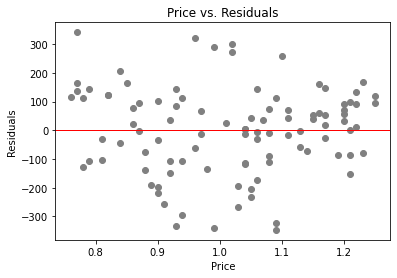

In [ ]:
plt.scatter(x= x[:,1], y= residuals, color='grey' )
plt.axhline(y=0, color='red', linewidth = 1)
plt.xlabel("Price")
plt.ylabel("Residuals")
plt.title('Price vs. Residuals')

Text(0, 0.5, 'Predicted Demand')

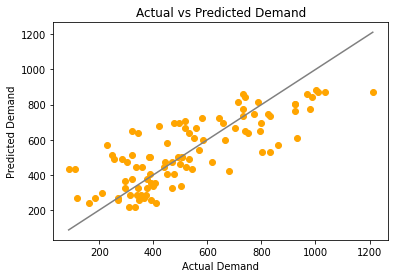

In [ ]:
line = np.arange(price_demand_data['demand'].min(), price_demand_data['demand'].max())
plt.plot(line, line, color='grey')
plt.title('Actual vs Predicted Demand')
plt.scatter(price_demand_data['demand'],y_hat,color='orange' )
plt.xlabel('Actual Demand')
plt.ylabel('Predicted Demand')


## 2) Let c=0.5, g=0.75, and t=0.15. Using the residuals, assume the price is p=1 and generate demand data.

In [ ]:
g = 0.75
cost = 0.5
t = 0.15
price = 1.00

demand_with_price_1 = lr_model.predict(np.ones(x.shape))
demand_with_price_1= demand_with_price_1 + residuals
demand_with_price_1[:5]

array([351.38562621, 579.52024662, 472.21963007, 448.93724855,
       673.7489942 ])

## 3)Solve the optimal quantity to produce when p=1

In [ ]:
n = len(demand_with_price_1)
A = np.zeros((n*2, n+1))
b = np.zeros(A.shape[0])
sense = ['<']*A.shape[0]
obj = np.zeros(A.shape[1])
lb = [0] + [-np.inf]*n
ub = [np.inf] + list((price+t)*demand_with_price_1)
obj[1:] = 1/n


In [ ]:
for i in range(n):
    d = demand_with_price_1[i]
    A[i, [0, i+1]] = [cost-g, 1]
    b[i] = price*d - g*d
    A[n+i, [0, i+1]] = [cost+t, 1]
    b[n+i] = price*d + t*d

In [ ]:
model_for_price_1 = gp.Model()
model_for_price_1_x = model_for_price_1.addMVar(len(obj),lb=lb, ub=ub)

model_for_price_1_con = model_for_price_1.addMConstrs(A, model_for_price_1_x, sense, b) 
model_for_price_1.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)

model_for_price_1.Params.OutputFlag = 0 # 
model_for_price_1.optimize()

AttributeError: ignored

In [ ]:
~#the optimal quantity to produce when price=$1
optimal_quantity_price_1 = model_for_price_1.x[0]
print('Optimal Quantity for price=$1 :: ', optimal_quantity_price_1)

#the expected price to produce when price=$1
exp_profit_price_1 = model_for_price_1.objVal
print('Expected profit for price=$1 :: ', exp_profit_price_1)

## 4)Now let price impact demand and solve the resulting QP. What are the optimal price and quantity to print?

In [ ]:
def model_price_unknown(residuals, beta_0, beta_1):
    n = len(residuals)
    A = np.zeros((n*2, n+2))
    b = np.zeros(A.shape[0])
    sense = ['<']*A.shape[0]
    obj = np.zeros(A.shape[1])
    Q = np.zeros((A.shape[1], A.shape[1]))
    lb = [0] + [0] + [-np.inf]*n
    ub = [np.inf] + [np.inf] + [np.inf]*n
    obj[1] = beta_0 + np.mean(residuals)
    obj[2:] = 1/n

    Q[1, 1] = beta_1
    for i in range(n):
        eps = residuals[i]

        A[i, [0, 1, i+2]] = [cost-g,  g*beta_1, 1]
        b[i] = -g*beta_0 - g*eps 

        A[n+i, [0, 1, i+2]] = [cost+t, -t*beta_1, 1]
        b[n+i] = t*beta_0 + t*eps

    model_for_dynamic_price = gp.Model()
    model_for_dynamic_price_x = model_for_dynamic_price.addMVar(len(obj),lb=lb, ub=ub)

    model_for_dynamic_price_con = model_for_dynamic_price.addMConstr(A, model_for_dynamic_price_x, sense, b) 
    model_for_dynamic_price.setMObjective(Q,obj,0,sense=gp.GRB.MAXIMIZE)

    model_for_dynamic_price.Params.OutputFlag = 0  
    model_for_dynamic_price.optimize()
    
    return model_for_dynamic_price


In [ ]:
beta_0, beta_1 = lr_model.params

In [ ]:
model_for_dynamic_price=model_price_unknown(residuals, beta_0, beta_1)

In [ ]:
#the optimal quantity to produce when price is dynamic
optimal_quantity_dynamic_price = model_for_dynamic_price.x[0]
print('Optimal Quantity for dynamic price :: ', optimal_quantity_dynamic_price)

#the expected price to produce when price is dynamic
optimal_price = model_for_dynamic_price.x[1]
print('Optimal price :: ', optimal_price)

#the expected price to produce when price is dynamic  
exp_profit_dynamic_price = model_for_dynamic_price.objVal
print('Expected profit for dynamic price :: ', exp_profit_dynamic_price)

Optimal Quantity for dynamic price ::  535.2910009722485
Optimal price ::  0.9536264966232282
Expected profit for dynamic price ::  234.42493487066122


## 6) We are now interested to know how sensitive the optimal price and quantity are to our data set. Take a bootstrap sample of the original dataset. Go back and fit new beta’s to the new bootstrapped dataset and redo step 4. Find the optimal price and quantity.

In [ ]:
def lr_output(data_x):
    y, x = dmatrices('demand ~ price', data=data_x)
    lr_model = sm.OLS(y, x)  
    lr_model = lr_model.fit()
    beta_0, beta_1 = lr_model.params
    y_hat = lr_model.predict(x)
    residuals = y.flatten() - y_hat

    return residuals, beta_0, beta_1

In [ ]:
def bootstrap_func():
    index = np.random.randint(size= price_demand_data.shape[0], low= 0, high= price_demand_data.shape[0])
    bs_sample = price_demand_data.iloc[index].reset_index(drop= True)
    residuals, beta_0, beta_1 = lr_output(bs_sample)

    return model_price_unknown(residuals,beta_0, beta_1)

In [ ]:
model_bootstrap_q6 = bootstrap_func()

print("Output for 1 bootstrap sample\n")

#the optimal quantity to produce when price is dynamic
model_bootstrap_q6_price = model_bootstrap_q6.x[0]
print('Optimal Quantity for dynamic price of bootstrapped data:: ', model_bootstrap_q6_price)

#the expected price to produce when price is dynamic
optimal_price = model_bootstrap_q6.x[1]
print('Optimal price of bootstrapped data:: ', optimal_price)

#the expected price to produce when price is dynamic  
model_bootstrap_q6exp_profit_dynamic_price = model_bootstrap_q6.objVal
print('Expected profit for dynamic price of bootstrapped data :: ', model_bootstrap_q6exp_profit_dynamic_price)

Output for 1 bootstrap sample

Optimal Quantity for dynamic price of bootstrapped data::  545.2429458158845
Optimal price of bootstrapped data::  0.9508260483523963
Expected profit for dynamic price of bootstrapped data ::  238.68755736017442


## 7) Repeat this process of getting new bootstrapped data, fitting new betas to the newly simulated data and finding the optimal price/quantity many times. Make histograms of the optimal price and quantity. 

In [ ]:
boot_n = 10000

quantity_bs = []
price_bs = []
profit_bs = []

for i in tqdm(range(boot_n)):
    model_bootstrap_q7 = bootstrap_func()
    quantity_bs.append(model_bootstrap_q7.x[0])
    price_bs.append(model_bootstrap_q7.x[1])
    profit_bs.append(model_bootstrap_q7.objVal)
    
bootstrap_df = pd.DataFrame({'Profit': profit_bs, 'Price': price_bs, 'Quantity': quantity_bs})
bootstrap_df[:5]

100%|██████████| 10000/10000 [03:09<00:00, 52.84it/s]


,Profit,Price,Quantity
0,227.301268,0.962783,501.422119
1,250.729145,0.952120,556.716300
2,237.392801,0.953987,536.679277
3,248.096764,0.958335,559.870839
4,234.965257,0.950703,541.105875


## Make a scatterplot with histograms on the x and y axis for this. You can do this quite easily using ggplot2.

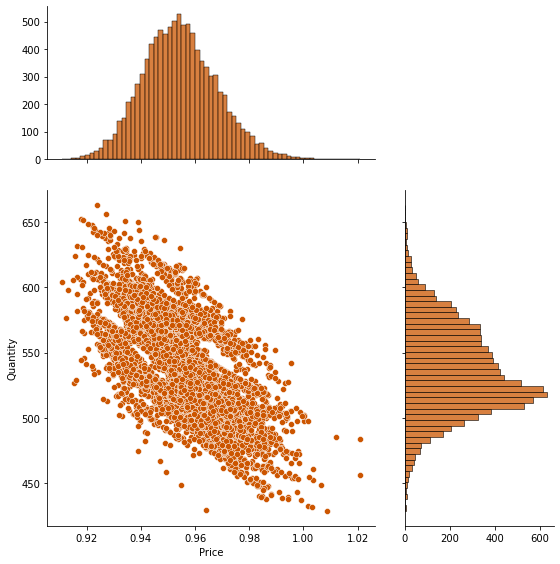

In [ ]:
sns.jointplot(data = bootstrap_df, x = 'Price', y = 'Quantity', height = 8, ratio = 2, marginal_ticks = True, color='#CC5500')



##  Make a histogram of expectation of profits.

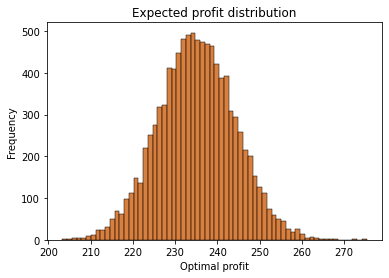

In [ ]:
plt.figure()
sns.histplot(bootstrap_df['Profit'],color='#CC5500')
plt.xlabel('Optimal profit')
plt.ylabel('Frequency')
plt.title('Expected profit distribution')
plt.show()

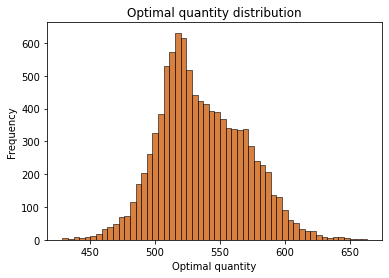

In [ ]:
plt.figure()
sns.histplot(bootstrap_df['Quantity'],color='#CC5500')
plt.xlabel('Optimal quantity')
plt.ylabel('Frequency')
plt.title('Optimal quantity distribution')
plt.show()

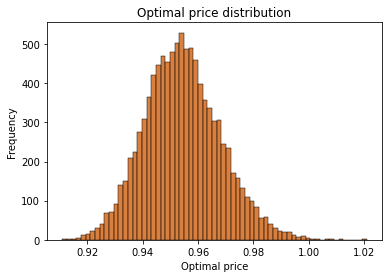

In [ ]:
plt.figure()
sns.histplot(bootstrap_df['Price'],color='#CC5500')
plt.xlabel('Optimal price')
plt.ylabel('Frequency')
plt.title('Optimal price distribution')
plt.show()

## 8) You work for a publishing company. Your boss has been using the standard NV model to set printing decisions using the dataset given. Is your boss’ model as good as this one? Could you increase revenue by switching models for production/pricing decisions? Describe the advantages and disadvantages of both techniques. Your boss is pretty technical and understands optimization, so don’t be afraid to include quantitative material. Your boss is also busy, so be sure to include some visualizations to get the important points across. For the purpose of your report, you can assume that your boss is interested in the data posted with the project. Write this as if you were going to give it to your boss as a technical report that may be shared with the CEO. That means, make it look GOOD!

In [ ]:
# 100 decision variables: (q, h1, h2, ..., h99)
obj = np.zeros(n+1)
obj[1:] = 1.0/n
lb = np.zeros(n+1)
lb[1:] = -np.inf # quantity printed needs to be non-negative, but profit on a given day could possibly be negative
rhs = np.zeros(2*n)
direction = np.array(['<']*(2*n))

A = np.zeros((2*n, n+1))
for r in range(n):
    A[2*r,[0,r+1]] = [cost,1] # location 1 is q, location r+1 is this h
    rhs[2*r] = price*df_new.demand[r]
    A[2*r+1,[0,r+1]] = [cost-price,1]
    rhs[2*r+1] = 0

baseline = gp.Model()
baseline_x = baseline.addMVar(len(obj),lb=lb) 
baseline_con = baseline.addMConstr(A, baseline_x, direction, rhs) 
baseline.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)

baseline.Params.OutputFlag = 0
baseline.optimize()

In [ ]:
baseline_quantity = baseline.x[0]
baseline_profit = baseline.objVal
print('Optimal quantity', baseline_quantity, 'Optimal profit', baseline_profit)

Optimal quantity 569.8967553157715 Optimal profit 219.28316552851413


In [ ]:
# comparision of baseline profit with the distribution of dynamic pricing approach
# 95% confidence interval for dynamic priceing approach

# low = 0.025
# high = 0.975
low = 0.05
high = 0.95

low_q, high_q = np.quantile(bootstrap_df['Quantity'], [low, high])
low_profit, high_profit = np.quantile(bootstrap_df['Profit'], [low, high])
low_c, high_c = np.quantile(bootstrap_df['Price'], [low, high])

if (baseline_profit < low_profit):
    print('Baseline NV approach gives low profit')
elif (baseline_profit > high_profit):
    print('Baseline NV approach gives High profit')
else:
    print('No significant difference in profit between the baseline NV and the dynamic price approach was observed.')

if (baseline_quantity < low_q):
    print('Baseline NV approach gives low quantity')
elif (baseline_quantity > high_q):
    print('Baseline NV approach give high quantity')
else:
    print('No significant difference in quantity between the baseline NV and the dynamic price approach was observed.')

if (p < low_c):
    print('Baseline NV approach sell at low price')
elif (p > high_c):
    print('Baseline NV approach sell at high price')
else:
    print('No significant difference in price between the baseline NV and the dynamic price approach was observed.')

Baseline NV approach gives low profit
No significant difference in quantity between the baseline NV and the dynamic price approach was observed.
Baseline NV approach sell at high price


**Despite charging lower prices to customers, the dynamic pricing approach enables us to achieve both a higher profit and a higher quantity produced.**

In [ ]:
#Profit mean comparison with confidence values low = 5% and high = 95%
print('Profit')
print('Baseline', round(baseline_profit, 2))
print('Dynamic Profit', round(np.mean(bootstrap_df['Profit']), 2), round(low_profit, 2), round(high_profit, 2))
print('')

#Price mean comparison with confidence values low = 5% and high = 95%
print('Price')
print('Baseline', round(1, 2))
print('Dynamic Price', round(np.mean(bootstrap_df['Price']), 2), round(low_c, 3), round(high_c, 3))
print('')

#Quantity mean comparison with confidence values low = 5% and high = 95%
print('Quantity')
print('Baseline', round(baseline_quantity, 2))
print('Dynamic Quantity', round(np.mean(bootstrap_df['Quantity']), 2), round(low_q, 3), round(high_q, 3))

Profit
Baseline 219.28
Dynamic Profit 235.09 220.16 250.05

Price
Baseline 1
Dynamic Price 0.95 0.933 0.978

Quantity
Baseline 569.9
Dynamic Quantity 536.28 486.952 592.471


In [ ]:
print(np.quantile(bootstrap_df['Quantity'], [0.05, 0.95]))
print(np.quantile(bootstrap_df['Profit'], [0.05, 0.95]))
print(np.quantile(bootstrap_df['Price'], [0.05, 0.95]))

[486.95233357 592.47057442]
[220.15651874 250.05434596]
[0.93287169 0.97813454]


In [ ]:
print(np.quantile(bootstrap_df['Quantity'], [0.025, 0.975]))
print(np.quantile(bootstrap_df['Profit'], [0.025, 0.975]))
print(np.quantile(bootstrap_df['Price'], [0.025, 0.975]))

[476.94687837 602.38066322]
[217.15980848 252.951113  ]
[0.92896802 0.98313783]
